# Дисклеймер
    
1) Блок **`Feature Engineering`** состоит из нескольких частей, которые разбросаны по тетрадке. Все начинается с `pandas`-части, которая находится, соответственно, в блоке про `Pandas`
2) Часть материала бралась из этого гитхаба: [ссылка](https://github.com/a-milenkin/Competitive_Data_Science/tree/main/notebooks)

### Используемые библиотеки в файле:

Если Вы хотите воспользоваться этим файлом и самостоятельно прогнать код, то сначала запустите этот код в отдельной ячейке:

`!pip install -r requirements.txt`

In [1]:
# добавить и другие библиотеки!!
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Навигация:

* **[Организация и красота тетрадок](#organisational_part)**
* **[Обращение к файлам](#appealing_to_files)**
* **[Numpy](#numpy)** 
* **[Pandas](#pandas)**
    * **[Разделение переменных на числовые и строковые + Заполнение пропусков](#)**
* **[Matplotlib & Seaborn](#matplotlib&seaborn)** 
* **[Sklearn](#sklearn)** 
* **Важные этапы на соревнованиях:**
   * **[Валидация](#validation)**
       * **[Пример использования валидации в реальной задаче](#example_of_usage)**
   * **[Feature Engineering](#feature_engineering)**
       * **Подготовка данных**
       * **Генерация признаков**
       * **[Фильтрация признаков](#feature_selection)**
       * **[Pandas-приемчики](#pandas_features)**
* **<a href='#catboost'>CatBoost</a>**

<a id='organisational_part'></a>
# Организация и красота тетрадок
* **Навигация тетрадок** - можно изучить на примере, приведенном ранее
* **Избежание отображения предупреждений**
* **Базовые настройки для красивого отображения графиков**
* **Отслеживание прогресса работы цикла**


In [2]:
# после этого кода тетрадка не будут омрачена красными табличками с предупреждениями
import warnings
warnings.filterwarnings('ignore')

In [3]:
# какие-то настройки надо вставлять не в самом начале тетрадки, а перед каждым графиков
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

### 🧠 Прогресс-бары и параллельные вычисления (`tqdm` и `pandarallel`)

* **Случай одинарного цикла:**

In [4]:
from tqdm.autonotebook import tqdm
import time

for i in tqdm(range(100)):
    time.sleep(0.1)
    
print(i)

  0%|          | 0/100 [00:00<?, ?it/s]

99


* **Случай вложенных циклов:**

Надо использовать функцию `notebook.trange` из библиотеки `tqdm`

In [150]:
from tqdm import tnrange, tqdm_notebook
from time import sleep

for i in tqdm_notebook(tnrange(4), desc='1st loop', leave=False):
    for j in tqdm_notebook(tnrange(100), desc='2st loop', leave=False):
        sleep(0.01)

  0%|          | 0/4 [00:00<?, ?it/s]

1st loop:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

2st loop:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

2st loop:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

2st loop:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

2st loop:   0%|          | 0/100 [00:00<?, ?it/s]

С помощью той же библиотеки можно добавить прогресс-бар прямо в `pandas`. Для этого надо её инициализировать:

In [151]:
from tqdm import tqdm
tqdm.pandas()

После этого просто заменяем `apply()` на `progress_apply()`. То же самое можно сделать с функцией `map()` -> `progress_map()`.

In [162]:
import requests
df = pd.DataFrame(
    [i for i in range(100)],
    columns=["sample_column"]
)

In [163]:
%%time

def function_to_apply(i):
    r = requests.get(f'https://random-word-api.herokuapp.com/word').json()
    
    return r[0]

df['sample_word'] = df.sample_column.progress_apply(function_to_apply)
df.head(2)

100%|█████████████████████████████████████████| 100/100 [00:37<00:00,  2.63it/s]

CPU times: user 2.66 s, sys: 281 ms, total: 2.94 s
Wall time: 38 s


,sample_column,sample_word
0,0,replayed
1,1,idolizations


### 🤯 Параллельные вычисления

Полезные ссылки:
* **[Githab документации Pandarallel](https://github.com/nalepae/pandarallel#api)**
* **[Документация Pandarallel](https://nalepae.github.io/pandarallel/)**
* **[Блог с объяснением](https://sergeypotekhin.com/adding-parallel-computations-to-the-pandas-dataframes/?utm_source=habr&utm_medium=post&utm_campaign=social-networks&utm_content=post)**

In [158]:
# ! pip install pandarallel -q

**Важно отметить:**  Для параллелизации подходят достаточно простые функции, не использующие под капотом многопоточность, рекурсию и много побочных действий. Но всегда можно экспериментировать и смотреть, насколько **код работает быстрее**. Также при использовании `pandarallel` происходит почти двукратное **увеличение потребления оперативной памяти, что критично** при работе с большими датасетами.

In [165]:
%%time

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

df["sample-word"] = df.sample_column.parallel_apply(function_to_apply)
df.head(2)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


CPU times: user 136 ms, sys: 106 ms, total: 243 ms
Wall time: 6.36 s


,sample_column,sample_word,sample-word
0,0,replayed,emboss
1,1,idolizations,night


<a id='appealing_to_files'></a>
# Обращение к файлам

Для того, чтобы обратиться к файлу и открыть его в тетрадке, он должен лежать в той же директории, что и сама тетрадка. Иногда он может лежать в дополнительной папке, а не рядом с тетрадкой, поэтому для начала **получим путь к текущему рабочему каталогу**:

In [5]:
# get current working directory
current_path = os.getcwd()
print(current_path)

/Users/andrewnizov/Machine Learning/Летние проекты


In [6]:
# os.path.dirname() возвращает путь к родительскому катологу данного пути
common_path = os.path.dirname(os.getcwd())
print(common_path)

/Users/andrewnizov/Machine Learning


Для того, чтобы достать файл, который лежит в дополнительной папке текущего каталога, надо объединить `current_path` с относительным путем:

In [7]:
path = os.path.join(current_path, r'data/_end_seminar.xlsx')
df = pd.read_excel(path)
df.head(2)

,timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,percentile,17_group,blended,is_ml_student
0,2020-05-15 01:12:50.543,93ff79a51cd602f1dd3028ba2c129503,698,181.0,NaN,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да,0.183857,NaN,NaN,NaN
1,2020-05-15 02:46:48.066,26b01b1c4cd5656bab18d24c548834fb,647,181.0,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Дискретная оптимизация,Численные методы,Машинное обучение 2,Нет,0.426009,NaN,NaN,NaN


<a id='numpy'></a>
# Numpy

In [8]:
import numpy as np

Полезный пример использования **`np.where`**:

**Задача:** создать новый столбец, который будет называться `chances_to_study_in_italy`. там должно появиться три значения: `high_chances` (если перцентиль меньше 0.05), `medium_chances` (если перцентиль от 0.05 до 0.13) и `low_chances` иначе.

In [9]:
df['chances_to_study_in_italy'] = np.where(df['percentile'] <= 0.05, 'High chances', 
                                           np.where((df['percentile'] > 0.05) & (df['percentile'] <= 0.13), 
                                                    'Medium chances', 'Low chances'))

In [10]:
df.sample(3)

,timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,percentile,17_group,blended,is_ml_student,chances_to_study_in_italy
266,2020-05-17 19:44:23.500,d028e00edda581b07bcbe6b841e6dc39,1242,NaN,NaN,Байесовские методы машинного обучения,Анализ неструктурированных данных,Глубинное обучение в обработке звука,Обучение с подкреплением,Генеративные модели в машинном обучении,Компьютерное зрение,Да,0.166667,171.0,DevOps,NaN,Low chances
348,2020-05-18 23:54:25.376,cef24632489091cb8c085688b7d78dec,1095,NaN,NaN,Глубинное обучение в обработке звука,Сбор и обработка данных с помощью краудсорсинга,Анализ неструктурированных данных,Обучение с подкреплением,Генеративные модели в машинном обучении,Компьютерное зрение,Нет,0.717391,172.0,Соревновательный анализ данных,NaN,Low chances
150,2020-05-18 21:49:22.233,f8fab519d78047712c06798c8b7fe38f,561,185.0,1.0,Моделирование временных рядов,Теория баз данных,Язык SQL,Промышленное программирование на языке Java,Машинное обучение 2,Компьютерные сети,Нет,0.822870,NaN,NaN,NaN,Low chances


<a id='pandas'></a>
# Pandas

**Разделение переменных на числовые и строковые + Заполнение пропусков**

In [11]:
# сначала надо понять, какие в целом форматы данных есть в исследуемом датафрейме
df.dtypes[:3]

timestamp    datetime64[ns]
id                   object
rating                int64
dtype: object

In [12]:
# некоторые закодированные переменные (тут это `is_ml_student`) надо вручную переносить в список категориальных
num_features = [i for i in df.columns if (df.dtypes[i] == 'int64') | (df.dtypes[i] =='float64')]
cat_features = [i for i in df.columns if (df.dtypes[i] == 'datetime64[ns]') | (df.dtypes[i] =='object')]

In [13]:
# заполнение пропусков (самый простой метод: 0 или пустая строка)
df[num_features] = df[num_features].fillna(0)
df[cat_features] = df[cat_features].fillna('')

**Методы удаления и добавлния столбцов!**
* **Удаление столбцов или строк:** `df.drop(name, axis=0, inplace=True)`, где name - индекс строки или название столбца; **`axis=0` - обращение к строке; `axis=1` - обращение к колонке**.
* **Удаление дубликатов строк:** `df.drop_duplicates(subset=['column_name'(-s)], keep='first'/'last'/False, inplace=True)`, при этом `keep=False` <=> удаление всех дубликатов
* **Вставка в заданное место столбца:** `df.insert(loc, column, value)` - по умолчанию столбцы вставляются в конец

Возможности метода **`value_counts`**:

In [14]:
print('Сортировка по возрастанию:')
display(df.is_first_time.value_counts(ascending=True))
print('Вывод долей частот:')
display(df.is_first_time.value_counts(normalize=True))

Сортировка по возрастанию:


         2
Нет     51
Да     308
Name: is_first_time, dtype: int64

Вывод долей частот:


Да     0.853186
Нет    0.141274
       0.005540
Name: is_first_time, dtype: float64

**Сортировка DataFrame**

In [15]:
# по значениям
df.sort_values(by=['rating', '17_group'], ascending=False).head(7)
# по второму столбцу сортировка будет производиться только в случае равенства значений первого столбца

,timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,percentile,17_group,blended,is_ml_student,chances_to_study_in_italy
231,2020-05-14 21:52:43.844,3a7326c9e355a67d3805824ca34c4bc5,1457,0.0,0.0,Statistical Learning Theory,Высокопроизводительные вычисления,Statistical Learning Theory,Символьные вычисления,Численные методы,Символьные вычисления,Да,0.000000,173.0,Введение в дифференциальную геометрию,0.0,High chances
273,2020-05-18 12:39:47.722,7fe7df0d207babbf30249b3063ac1f26,1365,0.0,0.0,Высокопроизводительные вычисления,Сбор и обработка данных с помощью краудсорсинга,Моделирование временных рядов,Проектирование и разработка высоконагруженных ...,Методы сжатия и передачи медиаданных,Методы сжатия и передачи медиаданных,Да,0.007246,175.0,DevOps,0.0,High chances
323,2020-05-18 22:20:02.655,67e4ec4fe5c0601815692fbd6d403fb7,1335,0.0,0.0,Байесовские методы машинного обучения,Глубинное обучение в обработке звука,Statistical Learning Theory,Обучение с подкреплением,Проектирование и разработка высоконагруженных ...,Генеративные модели в машинном обучении,Да,0.014493,171.0,DevOps,0.0,High chances
250,2020-05-17 11:31:43.285,b3cbd3541c0cf66ff4eb2bc1596bb149,1333,0.0,0.0,Байесовские методы машинного обучения,Statistical Learning Theory,Моделирование временных рядов,Символьные вычисления,Обучение с подкреплением,Генеративные модели в машинном обучении,Да,0.021739,173.0,Соревновательный анализ данных,0.0,High chances
267,2020-05-17 22:08:57.825,840716fde17a536f5e067546ab49a8a7,1325,0.0,0.0,Байесовские методы машинного обучения,Глубинное обучение в обработке звука,Анализ неструктурированных данных,Генеративные модели в машинном обучении,Компьютерное зрение,Обучение с подкреплением,Да,0.028986,171.0,DevOps,0.0,High chances
347,2020-05-18 23:44:56.517,bb29d9b9230528a4873f91abce2095b8,1313,0.0,0.0,Безопасность компьютерных систем,Высокопроизводительные вычисления,Анализ неструктурированных данных,Методы сжатия и передачи медиаданных,Проектирование и разработка высоконагруженных ...,Символьные вычисления,Да,0.036232,175.0,DevOps,0.0,High chances
327,2020-05-18 22:43:00.850,dc7f705ae386b0457542a833571d51d0,1307,0.0,0.0,Высокопроизводительные вычисления,Моделирование временных рядов,Байесовские методы машинного обучения,Проектирование и разработка высоконагруженных ...,Методы сжатия и передачи медиаданных,Обучение с подкреплением,Нет,0.043478,173.0,DevOps,0.0,High chances


In [16]:
# по индексу
df.sort_index(axis=0, ascending=False).head(7)

,timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,percentile,17_group,blended,is_ml_student,chances_to_study_in_italy
360,2020-05-23 21:16:40.916,f2d210ace25a841e1e58036b257d5d47,1195,0.0,0.0,Анализ неструктурированных данных,Моделирование временных рядов,Высокопроизводительные вычисления,Обучение с подкреплением,Компьютерное зрение,Методы сжатия и передачи медиаданных,,0.369565,176.0,Соревновательный анализ данных,0.0,Low chances
359,2020-05-23 21:16:40.916,79d14db48e4737af731960ae212d5134,966,0.0,0.0,Безопасность компьютерных систем,Принятие решений в условиях риска и неопределё...,Анализ неструктурированных данных,Проектирование и разработка высоконагруженных ...,Методы сжатия и передачи медиаданных,Компьютерное зрение,Да,0.985507,172.0,DevOps,0.0,Low chances
358,2020-05-20 11:54:38.318,d7118b44c7e8fdbbaaca226d2da6fef1,1111,0.0,0.0,Сбор и обработка данных с помощью краудсорсинга,Statistical Learning Theory,Анализ неструктурированных данных,Проектирование и разработка высоконагруженных ...,Методы сжатия и передачи медиаданных,Численные методы,Да,0.652174,173.0,Соревновательный анализ данных,0.0,Low chances
357,2020-05-19 20:19:25.815,f44aea1095f9f5b8e2f5f0ed2b17891b,1060,0.0,0.0,Анализ неструктурированных данных,Высокопроизводительные вычисления,Моделирование временных рядов,Конфликты и кооперация,Обучение с подкреплением,Численные методы,Да,0.840580,174.0,DevOps,0.0,Low chances
356,2020-05-19 19:04:17.873,c5870b37ee3f672e4259dfb2fc02ed8f,1029,0.0,0.0,Statistical Learning Theory,Анализ неструктурированных данных,Сбор и обработка данных с помощью краудсорсинга,Обучение с подкреплением,Конфликты и кооперация,Компьютерное зрение,Да,0.920290,174.0,DevOps,0.0,Low chances
355,2020-05-19 18:58:06.283,ba298cbd9be59b84bab33325e956f27e,1155,0.0,0.0,Сбор и обработка данных с помощью краудсорсинга,Байесовские методы машинного обучения,Анализ неструктурированных данных,Конфликты и кооперация,Обучение с подкреплением,Компьютерное зрение,Да,0.507246,171.0,Соревновательный анализ данных,0.0,Low chances
354,2020-05-19 08:55:39.509,98c5a2548d93f26bd4195466e93178b3,1035,0.0,0.0,Байесовские методы машинного обучения,Глубинное обучение в обработке звука,Statistical Learning Theory,Обучение с подкреплением,Генеративные модели в машинном обучении,Методы сжатия и передачи медиаданных,Нет,0.905797,171.0,DevOps,0.0,Low chances


**Важный метод `apply` + `lambda-функция`**

In [17]:
df['is_first_time'] = df['is_first_time'].apply(lambda x: 1 if x == 'Да' else 0)
df.head()

,timestamp,id,rating,18_group,is_mi,fall_1,fall_2,fall_3,spring_1,spring_2,spring_3,is_first_time,percentile,17_group,blended,is_ml_student,chances_to_study_in_italy
0,2020-05-15 01:12:50.543,93ff79a51cd602f1dd3028ba2c129503,698,181.0,0.0,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,1,0.183857,0.0,,0.0,Low chances
1,2020-05-15 02:46:48.066,26b01b1c4cd5656bab18d24c548834fb,647,181.0,0.0,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Дискретная оптимизация,Численные методы,Машинное обучение 2,0,0.426009,0.0,,0.0,Low chances
2,2020-05-15 03:12:41.480,30f3653fc176d54e89ac3179c455c6dd,624,185.0,0.0,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов,Дискретная оптимизация,Машинное обучение 2,Численные методы,1,0.538117,0.0,,0.0,Low chances
3,2020-05-15 04:43:08.994,1528f0eaa027580820ccf0d92a53ad68,579,182.0,0.0,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,1,0.744395,0.0,,0.0,Low chances
4,2020-05-15 07:47:17.197,496ea4f0d4abe264b1bb1b80eb3830c5,572,183.0,0.0,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных,Компьютерные сети,Дискретная оптимизация,Численные методы,1,0.780269,0.0,,0.0,Low chances


`groupby` VS `pivot_table`

In [18]:
# возможности groupby, прелесть .agg()
df.groupby('is_ml_student').mean()

,rating,18_group,is_mi,is_first_time,percentile,17_group
is_ml_student,,,,,,
0.0,862.144737,100.891447,0.059211,0.848684,0.534849,78.694079
1.0,679.754386,183.807018,0.000000,0.877193,0.296594,0.000000


Преимущества использования **`.agg()`**:
* Применение различных агрегирующих функций к разным столбцам.
* Применение нескольких агрегирующих функций к одному столбцу.
* Применение пользовательских функций для агрегирования.
* Более гибкое и мощное управление процессом агрегирования.

In [19]:
def the_most_frequent(series):
    # idxmax выводит индекс элемента с самым большим значением по указанной оси
    if series.all() == 0:
        return 'нет разделения'
    else:
        f = series.value_counts().idxmax()
        return f

# часто стоит приравнивать параметр as_index к False, чтобы эти новые признаки добавить к основной таблице через merge
interesting_info = df.groupby('is_ml_student', as_index=True).agg(
    mean_rating=('rating', 'mean'),
    hype_in_18_group=('18_group', the_most_frequent),
    count_is_mi=('is_mi', 'count'),
    count_is_first_time=('is_first_time', 'count'),
    min_percentile=('percentile', 'min'),
    max_percentile=('percentile', 'max'),
    median_percentile=('percentile', 'median'),
    hype_in_17_group=('17_group', the_most_frequent)
)
interesting_info

,mean_rating,hype_in_18_group,count_is_mi,count_is_first_time,min_percentile,max_percentile,median_percentile,hype_in_17_group
is_ml_student,,,,,,,,
0.0,862.144737,нет разделения,304,304,0.0,0.995516,0.549335,нет разделения
1.0,679.754386,182.0,57,57,0.0,0.946188,0.228700,нет разделения


### Способ профи: `groupby()` + `transform()`

Это очень удобная замена `groupby()`+`agg()` **+** `merge()`

In [137]:
rides = pd.read_csv('https://stepik.org/media/attachments/lesson/779916/3_1_5.csv')
rides['mean_rating'] = rides.groupby(by=['car_id'], as_index=False)['rating'].transform('mean')
rides.head(3)

,car_id,ride_id,user_id,rating,ride_cost,true_car_ride_count,true_user_rating_max,true_user_ride_cost_mean,mean_rating
0,D17587481H,E1V,Q20675647n,1.96,282,3,1.96,282.0,5.466667
1,w13176062d,V1h,O11803938a,4.45,308,4,4.45,308.0,3.907500
2,s-2202835E,B1g,u20234217o,2.76,525,4,2.76,525.0,2.272500


`pd.concat` VS `pd.merge` VS `np.concatenate`

### Важно! 
При использовании методов `pd.concat` или `np.concatenate` нельзя явно указать, по какому столбцу надо объединить таблицы. Там по умолчанию таблицы будут соеденены по индексам!

В функции **`pd.merge`** надо указать следующие параметры: **`dataset=..`**, **`on=..`** (по какому общему столбцу/строке будут объеденены таблицы) и **`how=..`** (каким образом надо объединить таблицы? `inner`/`outer`/`left`/`right`)

Допустим, надо объединить таблицы по столбцу `id`:
* **`inner`** - оставит только те строки, где значения `id` есть и в `df1`, и в `df2`
* **`outer`** - оставит все строки: и с уникальными значениями `id`, которые есть как в `df1`, так и в `df2`, и с пересечениями в значениях `id`
* **`left`** - оставит только те строки, где значения `id` есть в `df1`
* **`right`** - оставит только те строки, где значения `id` есть в `df2`

In [122]:
rides = pd.read_csv('https://stepik.org/media/attachments/lesson/779916/3_1_4_rides.csv')
cars = pd.read_csv('https://stepik.org/media/attachments/lesson/779916/3_1_4_cars.csv')

In [131]:
rides.shape, cars.shape

((50, 5), (7, 4))

In [128]:
rides.merge(cars, on='car_id', how='inner')

,car_id,ride_id,rating,ride_duration,ride_cost,model,riders,target_class
0,L-1156474z,u1g,5.81,33,391,Tesla Model 3,39718,break_bug
1,M20797256F,e1V,5.01,56,667,Renault Sandero,65913,engine_overheat
2,E16896376o,B1Q,4.88,26,228,VW Polo VI,89960,engine_overheat
3,E16896376o,V1L,6.98,37,512,VW Polo VI,89960,engine_overheat
4,X10754765V,M1i,1.62,29,312,VW Tiguan,125986,electro_bug
5,s-1723833v,I1q,3.94,63,813,BMW 320i,58695,engine_check


**Вывод:** видно, что изначально общее количество строк в двух таблицах составляло 57 штук. при использовании `how='inner'` это количество значительно сократилось!

In [136]:
print(f"outer: {rides.merge(cars, on='car_id', how='outer').shape}, right: {rides.merge(cars, on='car_id', how='right').shape}, left: {rides.merge(cars, on='car_id', how='left').shape}")

outer: (52, 8), right: (8, 8), left: (50, 8)


<a id='pandas_features'></a>
### Pandas Feature Engineering
* Всемогущая функция `apply`!!
* Фишечки с `groupby` в связки с другими функциями

**Всемогущая функция apply!!**

In [67]:
url = 'https://drive.google.com/uc?id=1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-'  
rides = pd.read_csv(url)

In [68]:
rides.sample(3)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
59794,b26421033r,E-1789284H,A1S,2020-02-29,6.84,90,1255,33,133.0,1,1177.846118,0,-0.570678,0.909
375981,q20544928e,a35746775Z,r1F,2020-03-15,4.19,59,821,28,72.0,1,761.855860,0,-0.547159,-6.199
356196,e14987583Y,Z13225783s,R1K,2020-01-10,3.90,51,660,46,70.0,0,2394.697588,0,-2.448459,0.001


*Пример с **apply**, примененном к одному столбцу:*

In [89]:
the_greatest_function = lambda x: 'more_30' if x>30 else 'less_or_equal_30'

rides['speed_avg_greater_30'] = rides['speed_avg'].apply(the_greatest_function)
rides.sample(2)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,speed_avg_greater_30,new_feature
657291,O20261216l,u-6774973B,F1Y,2020-02-19,8.42,37,477,51,87.0,1,1776.141870,0,10.484829,-39.237,more_30,0.586207
569503,m19594037B,o-2324110V,P1G,2020-01-01,2.98,44,479,49,81.0,1,2044.885728,0,-2.955713,3.939,more_30,0.604938


*Пример с **apply**, примененном к двум столбцам:*

In [79]:
def A_devide_by_B(x):
    return x['speed_avg']/x['speed_max']

rides['new_feature'] = rides.apply(A_devide_by_B, axis=1) #если apply применяется к таблице, то важно указывать axis!!
rides.head(2)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,speed_avg_greater_30,new_feature
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909,more_30,0.317045
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133,more_30,0.387097


*Пример с **apply**, примененном к трем столбцам:*

**Задание:** Создайте в `df` новый столбец `final_ride_cost`, который будет зависеть от рейтинга (`rating`) и максимальной скорости (`speed_max`) поездки. Значения в этом столбце будут отличаться в зависимости от двух условий:

* Если рейтинг выше 6 и максимальная скорость поездки меньше 120 км/ч, то стоимость поездки (`ride_cost`) уменьшите на 5%.

* В противном случае: стоимость поездки (`ride_cost`) увеличьте на 5%.

В новом столбце `final_ride_cost` отбросьте дробную часть значений, оставьте только целую часть. Так как стоимость измеряется в рублях, дробная часть не имеет значения.

In [87]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/779916/3_1_2.csv')

def lets_fix_cost(df):
    if (df['rating'] > 6) & (df['speed_max'] < 120):
        return int(df['ride_cost'] * 0.95)
    else:
        return int(df['ride_cost'] * 1.05)

df['final_ride_cost'] = df.apply(lets_fix_cost, axis=1)
df.head()

,user_id,rating,speed_max,ride_cost,true_final_ride_cost,final_ride_cost
0,J19512539T,6.73,78.000000,4934,4687,4687
1,B22315336q,7.46,72.000000,235,223,223
2,y82944196A,4.86,168.181029,63835,67026,67026
3,G66226901h,7.70,74.000000,780,741,741
4,V24342105N,1.09,127.000000,891,935,935


**Фишечки с `groupby` в связки с другими функциями:**

* `groupby()` + `count`/`mean`/`sum`/`median` **и** `groupby()` + `agg()` были упомянуты ранее

* `groupby()` + `agg()` + `tuples`

In [90]:
rides = pd.read_csv('https://drive.google.com/uc?id=1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-' )

In [121]:
my_func = lambda x: int(np.nanmax(x) - np.nanmin(x))
rides_gr = rides.groupby("car_id", as_index=False).agg(rating_mean=("rating", "mean"),
                                                       ride_duration_sum=("ride_duration", 'sum'),
                                                       ride_cost_max=("ride_cost", "max"),
                                                       my_func_result=("speed_max", my_func)
)

rides_gr.head(2)

,car_id,rating_mean,ride_duration_sum,ride_cost_max,my_func_result
0,A-1049127W,4.255172,224292,330149,147
1,A-1079539w,4.088046,373893,638746,144


<a id='matplotlib&seaborn'></a>
# Matplotlib & Seaborn

У matplotlib, конечно же, есть [документация](https://matplotlib.org/users/index.html) с большим количеством [примеров](https://matplotlib.org/examples/), но для начала достаточно знать про несколько основных типов графиков:
- plot — обычный поточечный график, которым можно изображать кривые или отдельные точки;
- hist — гистограмма, показывающая распределение некоторой величины;
- scatter — график, показывающий взаимосвязь двух величин;
- bar — столбцовый график, показывающий взаимосвязь количественной величины от категориальной.

**5 пунктов после которых ваши графики не будут прежними:**
- для красивой картинки <code>%config InlineBackend.figure_format = 'retina'</code>
- задаем размер (почти) всех графиков (можно выбрать другие значения) <code>plt.rcParams['figure.figsize'] = 8, 5</code>
- размер шрифта подписей графиков <code>plt.rcParams['font.size'] = 12</code>
- формат в котором сохраняется изображение <code>plt.rcParams['savefig.format'] = 'pdf'</code>
- sns – seaborn, добавляет решетку <code>sns.set_style('darkgrid')</code>

### Нужно исследовать определенную зависимость! - какой график для этого лучше использовать?

* **`countplot`** - может понадобиться для исследования зависимости **двух категориальных переменных**

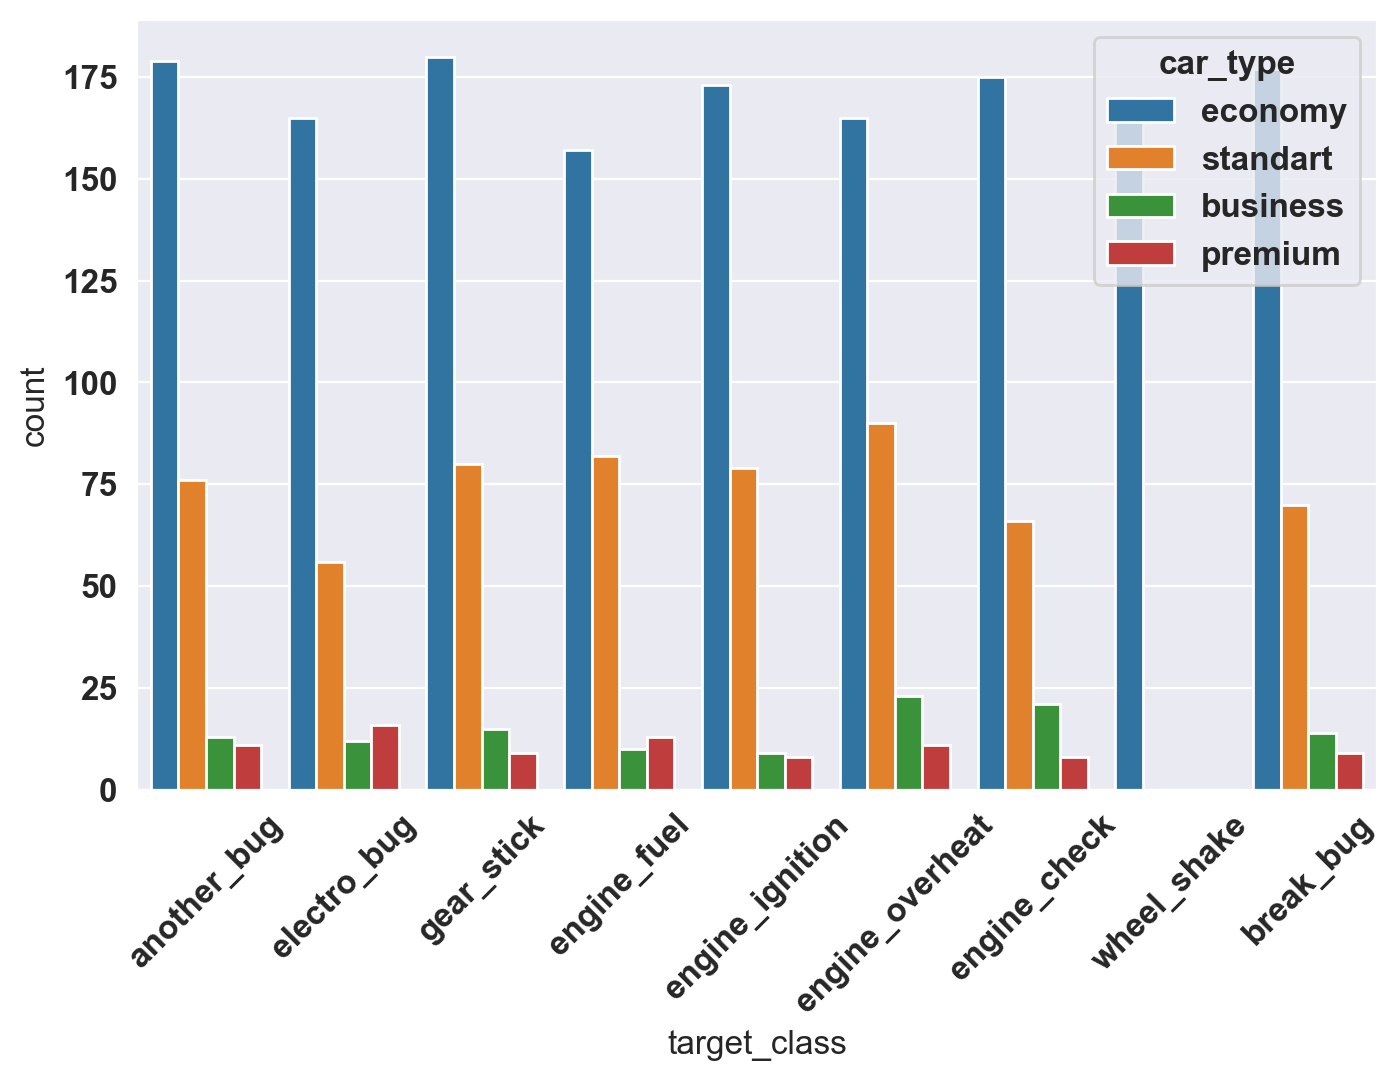

In [20]:
path = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv'
df = pd.read_csv(path)

my_plot = sns.countplot(data=df, x='target_class', hue='car_type')
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45);

***Замечание:*** `relplot`-ом может спокойно заменить `lineplot` и `scatterplot`, если использовать настраиваемый параметр `kind`.
Неплохо подходит для отображения **временных данных** на графике

In [167]:
train = pd.read_csv("data/car_train.csv")
rides = pd.read_csv("data/rides_info.csv")

rides = train.merge(rides, on="car_id", how="left")
rides.head(4)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,5.72,220,3514,42,NaN,6,1.682556e+03,0,0.524750,0.0
1,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2.52,37392,523483,45,53.0,2,1.711379e+06,0,1.723151,0.0
2,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,7.17,45,444,54,82.0,0,9.523155e+02,0,0.876440,-0.0
3,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,6.19,10,105,35,40.0,0,2.372539e+02,0,1.274242,-0.0


In [168]:
# Как ведет себя deviation_normal в времени для 10 автомобилей
tmp = rides
cols2select = [ "deviation_normal", "ride_date", "target_class", "car_id", "user_ride_quality", ]
ids2select = ["f-4873956c", "p-7109749V", "p-3304414p", "f-1300760u", "L-4452446Z"]
tmp = tmp[tmp["car_id"].isin(tmp.car_id.sample(1000, random_state=8).unique()[:15])]
tmp = tmp[tmp["car_id"].isin(ids2select)][cols2select]

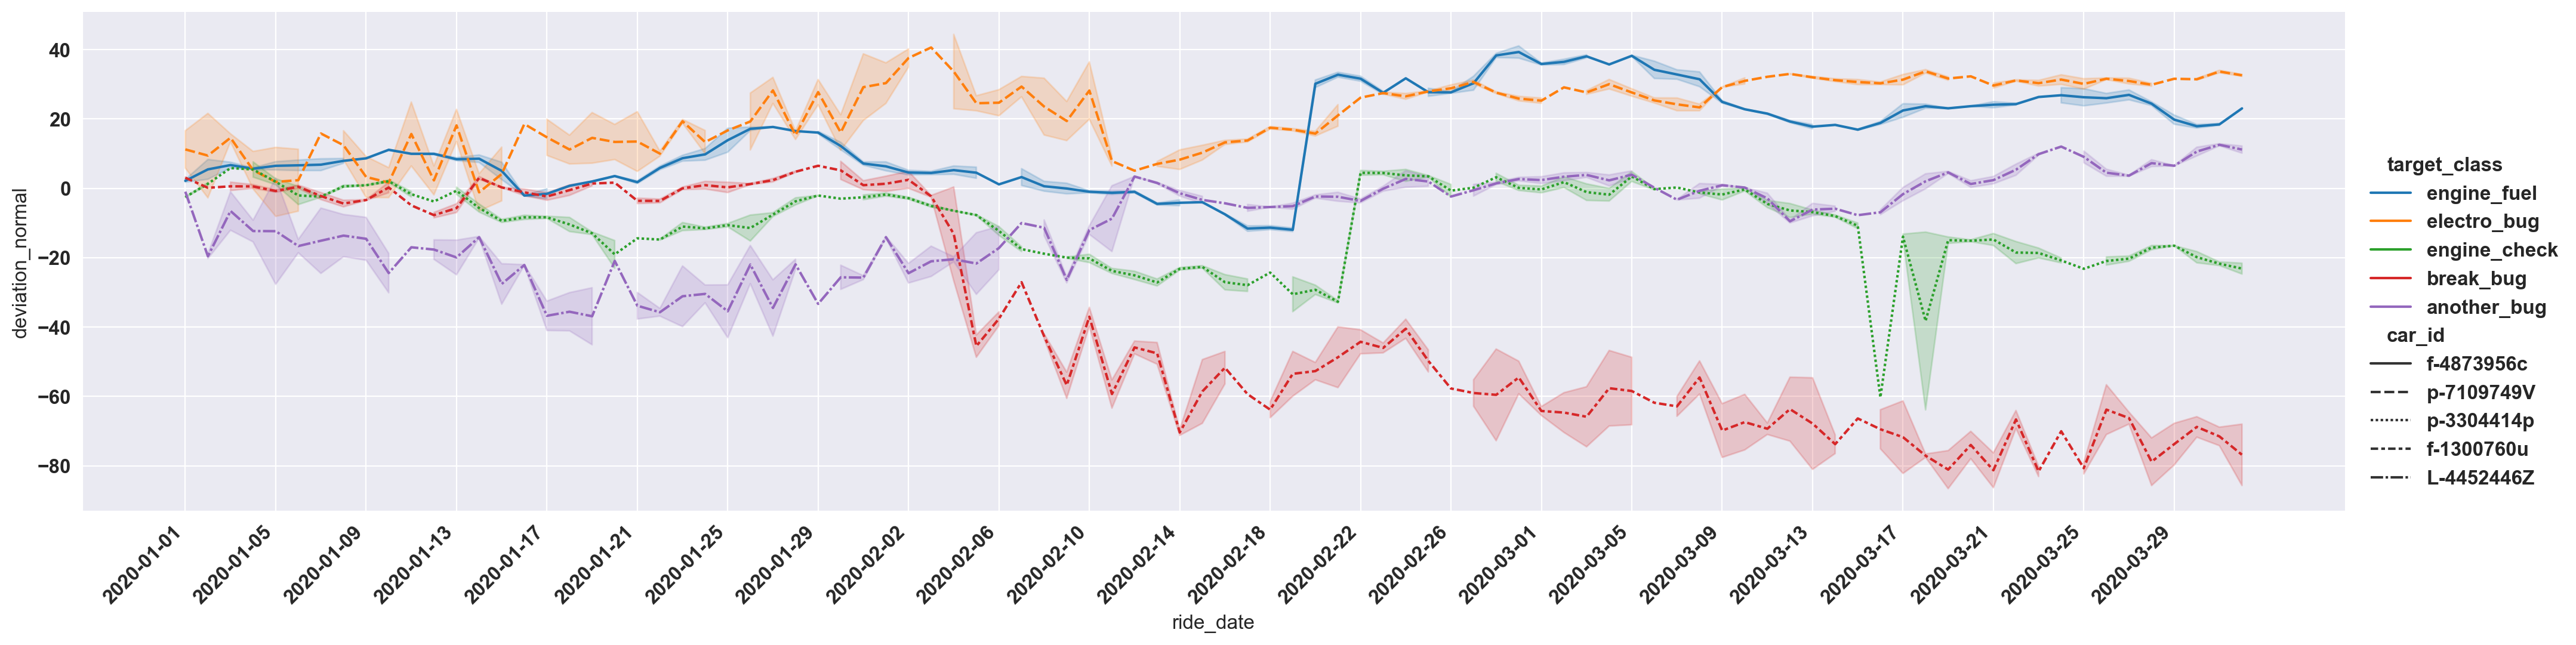

In [170]:
g = sns.relplot(
    data=tmp,
    kind="line",
    x="ride_date",
    y="deviation_normal",  # user_ride_quality
    hue="target_class",
    aspect=4,
    style="car_id",
    legend=True,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=4);

***Замечание:*** `displot`-ом может спокойно заменить `histplot`, `kdeplot` и `ecdfplot`, если использовать настраиваемый параметр `kind`.

**Вывод распределения всех признаков, которые есть в таблице:**

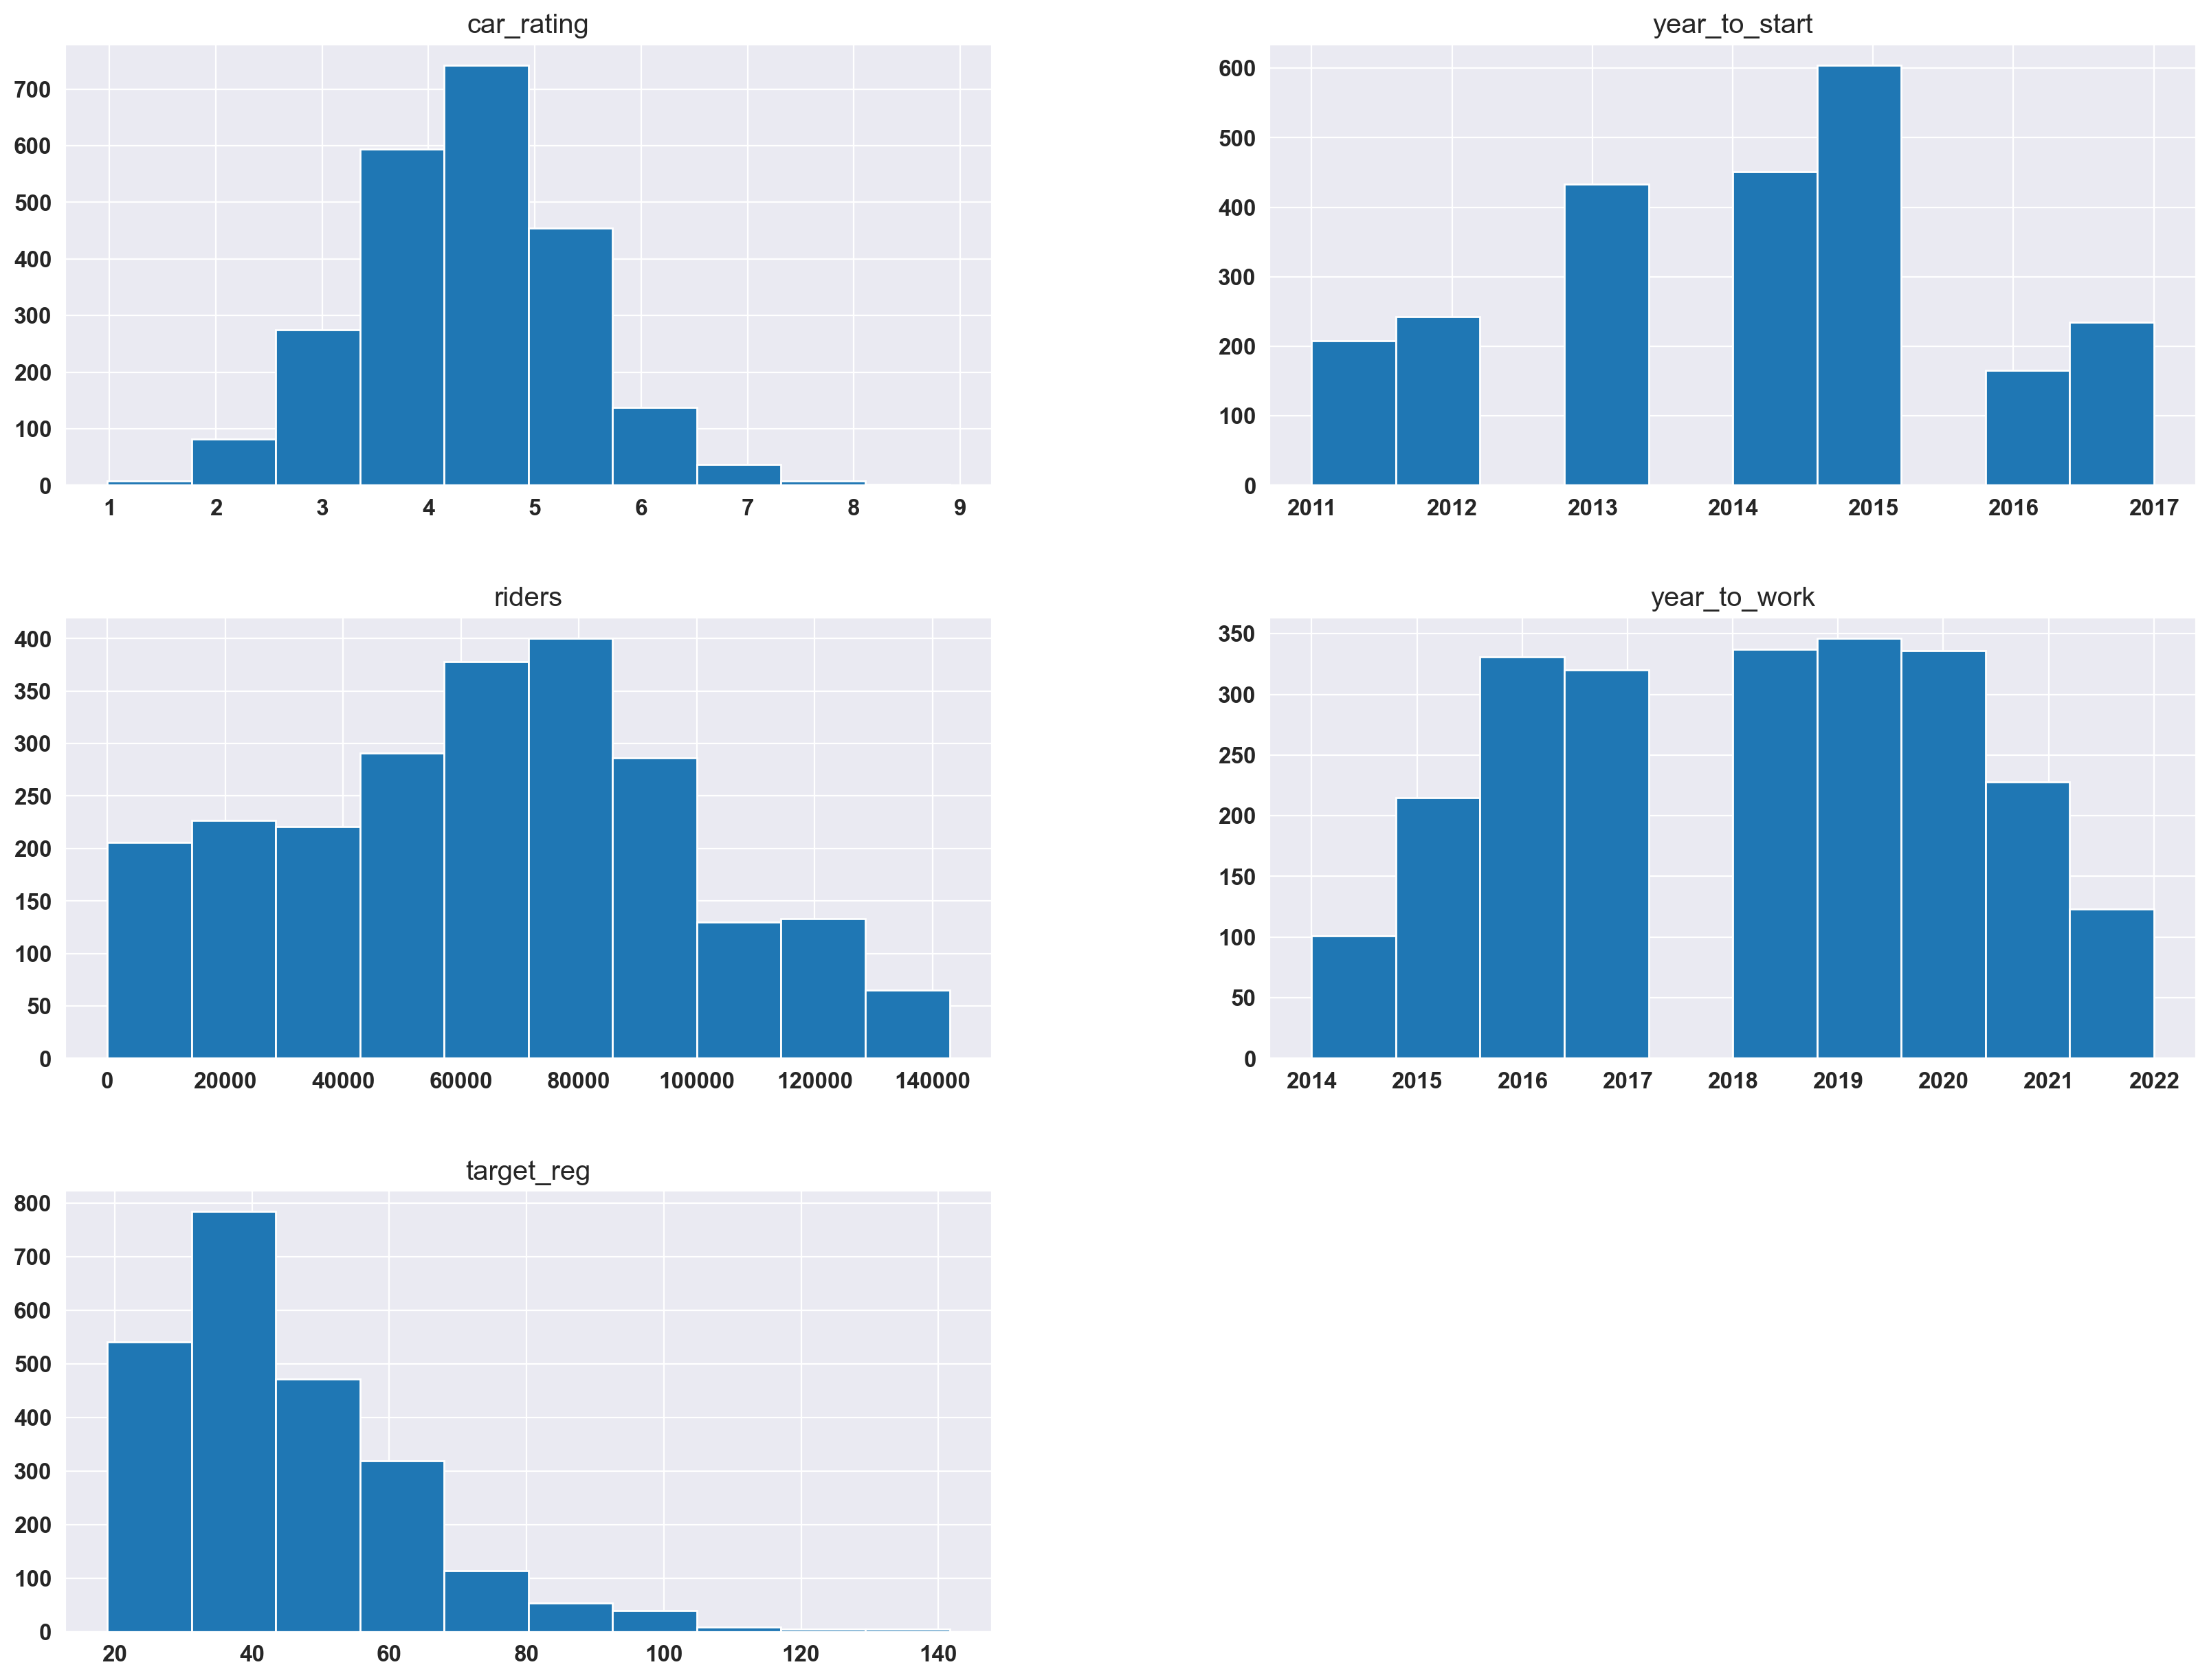

In [21]:
# пример построения графиков через методы Pandas
df.hist(figsize=(20, 15), layout=(-1, 2));

**Дефолтное оформление графиков (оси + подписи):**

**Расположение нескольких графиков на одном полотне:**

**Сохранение графиков в pdf формате**

<a id='sklearn'></a>
# Sklearn
https://scikit-learn.ru/user_guide/
   * Обучение модели
   * Преобразователи и препроцессоры (для нормализации и кодирования категориальных переменных) - **sklearn.preprocessing**
   * Объединение преобразователя и предиктора в **Pipeline** + Оценка качества обученной модели
   
    

* **fit** - метод обучения. Обычно принимает **2 аргумента**: X (матрица объекты-признаки) и y (вектор целевых переменных).
    * Пример применения:

In [22]:
# создание модели с фиксацией сида
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# количество объектов (строк) в матрице X должно совпадать с количеством значений таргетов
X = [[1, 2, 3],
    [8, 5, 2]]
y = [10, 44]

# обучение модели
clf.fit(X, y)
clf


RandomForestClassifier(random_state=42)

* **"scaler"** - метод стандартизации количественных признаков. Не имеет метода прогнозирования, только метод преобразования. То есть вид матрицы при выводе остается неизменным.
    * Пример применения:

In [23]:
from sklearn.preprocessing import StandardScaler

X = [[9, 4], 
    [10, 32]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled

array([[-1., -1.],
       [ 1.,  1.]])

* **make_pipeline + predict(X_test)** - второй метод предсказания на вход принимает тестовую выборку (матрица объекты-признаки) и на выходе выдает `y_test` (прогноз обученной модели по тестовым данным). 
    * Пример применения:

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pipeline = make_pipeline(
    StandardScaler(), 
    LogisticRegression()
)

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# в пайплайне автоматически применится transform для StandardSCaler
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy_score(y_pred, y_test)

1.0

* **cross-validation** - более надежный вариант разделения данных на обучающую и тестовую выборки

In [25]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

X, y = make_regression(n_samples=1000, random_state=0)
lr = LinearRegression()

result = cross_validate(lr, X, y) # 5 folds по умолчанию
result

{'fit_time': array([0.27143097, 0.27216005, 0.37684202, 0.26479793, 0.27132201]),
 'score_time': array([0.00616503, 0.02130628, 0.03744483, 0.0163281 , 0.02211976]),
 'test_score': array([1., 1., 1., 1., 1.])}

* **подбор гиперпараметров** с помощью встроенных в библиотеку `scikit-learn` инструментов: 
    * `GridSearchCV`: стоит использовать в случаях, когда пространство гиперпараметров небольшое (**инструмент вычислительно затратен**) и все комбанации гиперпараметров можно перебрать. этот иструмент ищет глобальный оптимум (**инструмент гарантирует нахождение наилучшей комбинации гиперпараметров** в пределах заданной сетки)
    * `RandomizedSearchCV`: инструмент **выбирает случайные наборы гиперпараметров** из заданной сетки. стоит использовать в случае, если нужно быстро найти хорошее решение, но при этом приемлем тот факт, что **решение не будет оптимальным**.
    * `HalvingGridSearchCV`: инструмент, который **достаточно быстро и тщательно** подбирает хороший набор гиперпараметров. **не гарантирует самой оптимальной комбинации**. работает следующим образом: **на первой итерации** `HalvingGridSearchCV` перебирает всевозможные наборы, используя малые вычислительные мощности (например, небольшое количество фолдов: 2-3). потом по указанному параметру (`factor`) инструмент сокращает количество наборов значений гиперпараметров, оставляя только лучшие. и **на последующих итерациях** использует все меньшее и меньшее количество комбинаций, используя все большие и большие вычислительные мощности (`resource` - например, `n_estimators`; `min_resources`; `max_recourses`).
    * `HalvingRandomSearchCV`: комбинирует принципы `HalvingGridSearchCV` и `RandomizedSearchCV`. Он **случайным образом выбирает наборы гиперпараметров, но с каждой итерацией уменьшает пространство поиска**, оставляя только наиболее перспективные комбинации.

Реализация этих методов очень схожа. Вот один из примеров:

In [26]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
# этот импорт нужен только в этом случае, потому что HalvingRandomSearchCV находится на экспериментальной стадии
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint
import numpy as np

X, y = load_iris(return_X_y = True)

clf = RandomForestClassifier(random_state=42)
np.random.seed(42)

# None <=> глубина дерева не ограничено и будет расти, пока все листья не станут с одним единственным классом
params = {'max_depth': [3, None, 5, 9], 
         'min_samples_split': randint(2, 20)}
# n_estimators в данном случае <=> количество деревьев в ансамбле
search = HalvingRandomSearchCV(clf, params, resource='n_estimators', max_resources=10, random_state=42)
search.fit(X, y)

print(search.best_score_)
print(search.best_params_)

0.96
{'max_depth': 9, 'min_samples_split': 13, 'n_estimators': 9}


Есть временная зависимость? ➡️ TimeSeriesSplit
Мало данных и быстро учится? ➡️ LeaveOneOut
Много данных, но быстро учится? ➡️ KFold
Очень много данных и долго учится? ➡️ старый добрый train_test_split()
Есть дисбаланс классов? ➡️ Любой итератор с приставкой Stratified
Есть группы и нельзя допусть их одновременного присутствия в train и test? ➡️ Любой итератор с приставкой Group

# Важные этапы на соревнованиях

<a id='validation'></a>
### Валидация
Основные методы для валидации находятся в **`sklearn.model_selection`**.

**CV** (перекрестная проверка)! тут ничего нового: есть k-1 фолдов, которые будут составлять обучающую выборку, оставшийся фолд - тестовую. В библиотеке `scikit-learn` есть обобщенный метод **`cross_validate(model, X, y, cv)`** (выводит словарь с ключами [`test_score`, `fit_time`, `score_time`] и также можно вывести эти данные сразу для нескольких метрик), который является наиболее простым, универсальным, но почти наименее гибким. Есть также функция **`cross_val_score(model, X, y, cv)`** - еще более упрощенная версия - которая выводит только массив оценок для каждой итерации кросс-валидации.

В случаях, когда понятно, какая стратегия перекрестной проверки лучше подходит для имеющихся данных, то стоит использовать один из данных итераторов CV (!!для iid данных!!): 
* **`KFold`** - кросс-итератор для K-фолдной валидации.
* **`StratifiedKFold`** - он же, но еще и стратифицированный (сбалансированный).
* **`GroupKFold`** - K-фрагментный вариант итератора с непересекающимися группами.
* **`RepeatedKFold`** - K-фолдная валидация с повторениями.

**Параметр, отвечающий за количество фолдов: `n_splits`**

Еще существуют такие:
* **`StratifiedGroupKFold`** - он же, но еще и стратифицированный (сбалансированный)
* **`RepeatedStratifiedKFold`** - а тут стратифицированный, но еще дополнительно с повторениям

И такие:
* **`Shuffle Split`** - сначала перемешивает все сэмплы, потом разделяет на заданное количество фолдов.
* **`Time Series Split`** - используется, когда данные упорядочены по времени.

* **`Leave One Out (LOO)`** - удаляет только 1 сэмпл данных из датасета для каждого фолда (создает все возможные наборы для обучения).
* **`Leave One Group Out`** - то же самое, но каждый раз удаляет 1 группу сэмплов.
* **`Leave P Out`** - удаляет P сэмплов из датасета и создает все возможные наборы, значения в наборах могут повторяться.


<div class='alert alert-info'>

# Когда какую выбрать? 
- Есть временная зависимость?  ➡️ `TimeSeriesSplit`
- Мало данных и быстро учится?  ➡️ `LeaveOneOut` 
- Много данных, но быстро учится?  ➡️ `KFold`
- Очень много данных и долго учится?  ➡️ `train_test_split()`
- Есть дисбаланс классов?  ➡️ **Любой** итератор с приставкой `Stratified`
- Есть группы и нельзя допусть их одновременного присутствия в `train` и `test`?  ➡️ **Любой** итератор с приставкой `Group`

**KFold**

In [27]:
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

kf = KFold(n_splits=5) # n_splits - количество фолдов

for train_index, test_index in kf.split(X):
    print('Oбучающая %s и тестовая %s' % (train_index, test_index))
    print()
print(X[train_index], y[train_index])

Oбучающая [ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149] и тестовая [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

Oбучающая [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 1

**StratifiedKFold**

In [28]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

X, y = np.ones((50, 1)), np.hstack(([0]*45, [1]*5))
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print('train - {} | test - {}'.format(np.bincount(y[train]), np.bincount(y[test])))

train - [30  3] | test - [15  2]
train - [30  3] | test - [15  2]
train - [30  4] | test - [15  1]


**TimeSeriesSplit**

Используется для работы с временными рядами, так как этот инструмент учитывает временную последовательность. С каждым новым разбиением увеличивается размер данных в обучающей выборке.

In [29]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

data = np.arange(10)

tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(data):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = data[train_index], data[test_index]
    print("X_train:", X_train, "X_test:", X_test)


TRAIN: [0 1 2 3] TEST: [4 5]
X_train: [0 1 2 3] X_test: [4 5]
TRAIN: [0 1 2 3 4 5] TEST: [6 7]
X_train: [0 1 2 3 4 5] X_test: [6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8 9]
X_train: [0 1 2 3 4 5 6 7] X_test: [8 9]


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

X = np.arange(100).reshape(-1, 1)
y = np.random.randn(100)

tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

scores = cross_validate(model, X, y, cv=tscv)
scores_1 = cross_val_score(model, X, y, cv=tscv)

print("Scores:", scores['test_score'])
print()
print("Scores:", scores_1)


Scores: [-4.15641811 -0.13489931 -0.70973198 -0.00840856 -0.03328982]

Scores: [-4.15641811 -0.13489931 -0.70973198 -0.00840856 -0.03328982]


<a id='example_of_usage'></a>
### Пример использования валидации в реальной задаче!

In [31]:
train = pd.read_csv("data/car_train.csv")
test = pd.read_csv("data/car_test.csv")
# train.hist(figsize=(25, 5), layout=(-1, 5))
train.sample(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1660,Y-1269300M,Smart ForFour,economy,petrol,5.14,2017,118389,2018,24.96,break_bug
1547,g-1495042h,Smart Coupe,economy,petrol,3.98,2017,122669,2018,72.70,another_bug
1094,F45462936z,Renault Kaptur,standart,petrol,4.30,2013,43308,2014,41.20,engine_overheat


In [32]:
rides = pd.read_csv('data/rides_info.csv')
rides.sample(3)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
591393,f86267018u,p81265760I,R1c,2020-03-15,2.91,38352,613628,62,99.52825,1,2.411691e+06,0,38.776270,21.570
668315,g82381071E,v-1632640v,M1F,2020-03-23,5.09,16301,260811,49,142.00000,2,8.128212e+05,0,-0.886411,44.305
347184,h96427934c,Z-1155909A,d1K,2020-01-29,0.10,775,10071,29,119.00000,4,7.014052e+02,0,1.859912,5.422


In [33]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(
    mean_rating=('rating', 'mean'),
    distance_sum=('distance', 'sum'),
    rating_min=('rating', 'min'),
    speed_max=('speed_max', 'max'),
    user_ride_quality_median=('user_ride_quality', 'median'),
    deviation_normal_count=('deviation_normal', 'count'),
    use_uniq=('user_id', f)
)
rides_df_gr.head(3)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,use_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173
2,A-1162143G,4.662299,2.995194e+06,0.1,180.000000,0.639653,174,172


Добавим **новые признаки** в общую таблицу:

Специально для реализации этого шага надо было использовать **`as_index=False`** в методе `groupby`.

In [38]:
def add_features(df):
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on='car_id', how='left')
    
    return df

train = add_features(train)
test = add_features(test)

In [39]:
train.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,use_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173


### Закодируем категориальные признаки!

In [41]:
cat_features = ['car_type', 'fuel_type', 'model']
train = pd.get_dummies(train, columns=cat_features)
test = pd.get_dummies(test, columns=cat_features)

KeyError: "None of [Index(['car_type', 'fuel_type', 'model'], dtype='object')] are in the [columns]"

### Классфицируем признаки

In [49]:
features2drop = ["car_id", "target_reg"]  # То, что можно выбросить
targets = ["target_class", "target_reg"]  # Таргеты
cat_features = ["car_type", "fuel_type", "model"]

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print("cat_features:", len(cat_features), cat_features)
print()
print("num_features:", len(num_features), num_features)
print()
print("targets:", *targets)

cat_features: 3 ['car_type', 'fuel_type', 'model']

num_features: 43 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'use_uniq', 'car_type_business', 'car_type_economy', 'car_type_premium', 'car_type_standart', 'fuel_type_electro', 'fuel_type_petrol', 'model_Audi A3', 'model_Audi A4', 'model_Audi Q3', 'model_BMW 320i', 'model_Fiat 500', 'model_Hyundai Solaris', 'model_Kia Rio', 'model_Kia Rio X', 'model_Kia Rio X-line', 'model_Kia Sportage', 'model_MINI CooperSE', 'model_Mercedes-Benz E200', 'model_Mercedes-Benz GLC', 'model_Mini Cooper', 'model_Nissan Qashqai', 'model_Renault Kaptur', 'model_Renault Sandero', 'model_Skoda Rapid', 'model_Smart Coupe', 'model_Smart ForFour', 'model_Smart ForTwo', 'model_Tesla Model 3', 'model_VW Polo', 'model_VW Polo VI', 'model_VW Tiguan', 'model_Volkswagen ID.4 ']

targets: target_class target_reg


### Учим `Random Forest` с `K-Fold` валидацией

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [58]:
X = train[filtered_features]
y = train[['target_class']]

In [66]:
n_splits = 5
clfs = []
scores = []

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for num, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf = RandomForestClassifier(
        n_estimators=2000,
        min_samples_leaf=4,
        n_jobs=-1,
        max_features=0.6,
        random_state=42,
        max_depth=6
    )
    
    clfs.append(clf)
    
    clf.fit(X_train, y_train['target_class'])
    
    y_pred = clf.predict(X_test)
    score = np.mean(np.array(y_pred == y_test['target_class']))
    scores.append(score)
    print(f'fold%s acc: %s' % (num, score))
    
assert len(clfs) == n_splits

print('mean accuracy score --', np.mean(scores, dtype='float16'), np.std(scores).round(4))

fold0 acc: 0.7841880341880342
fold1 acc: 0.8012820512820513
fold2 acc: 0.8094218415417559
fold3 acc: 0.7880085653104925
fold4 acc: 0.8051391862955032
mean accuracy score -- 0.798 0.0098


<div class="alert alert-info">

## TODO-лист хорошей валидации    
    
* Фиксируем все `random_state`!
* Сохраняем модели всех фолдов, для инференса!
* Считаем не только среднее, но и дисперсию [если дисперсия высокая (в зависимости от задачи), то имеет место оверфит или утечка данных (`dataleak`)]
* Прикручиваем раннюю остановку `Early Stopping`
* Считаем кастомную метрику соревнования (особенно, если она комплексная)

Для задачи **`multilabel classification`** можно использовать `MultilabelStratifiedKFold`, `MultilabelRepeatedStratifiedKFold` и `MultilabelStratifiedShuffleSplit` из [этой библиотеки](<https://github.com/trent-b/iterative-stratification>)!

<a id='feature_engineering'></a>
### Feature Engineering

<a id='feature_selection'></a>
### Feature selection

**!!** В данном случае не стоит доверять какому-то одному методу, лучше смотреть на несколько в купе, тем более если среди признаков есть "сцепленные".

Признаки, от которых можно сразу избавляться:
* Признаки-константы
* Признаки с уникальными значениями (`user_id`)

Как еще избавляться от признаков:
* Смотрим на **Phik-корреляцию** (которая учитывает нелинейные зависимости, категориальные признаки и тд) - **отсев признаков** происходит по маленьким значениям корреляции с таргетом
    * [Документация](https://pypi.org/project/phik/)
    * [Туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)
* Использование **feature importance** (например, в `CatBoostRegressor` есть `.feature_importance_`)
* Использование **permutation importance** (метод, который перетасовывает значения одного из признаков в случайном порядке и смотрит, насколько и как изменилась точность модели) - **более точный аналог feature importance!**
* Идея, которая мб не всегда работает: в качестве границы, по которой мы будем отсеивать признаки, создать рандомный признак (`np.random.randint`/`np.random.random`/`np.random.normal(loc = .., scale = .., size = ..)`)
* Использование **SHAP values**
* Семейства методов `Boruta`/`BoostARoota`
* Рекурсивные алгоритмы: удаляем признаки и смотрим, уменьшится ли качество. Если уменьшилось, значит признак вредный. пример см. далее...

В библиотеке `CatBoost` есть встроенный метод для отбора признаков select_features, который поддерживает 3 алгоритма отбора признаков - параметр algorithm:

* `RecursiveByPredictionValuesChange` - самый быстрый и достаточно точный
* `RecursiveByLossFunctionChange` - оптимальный по соотношению точность/скорость
* `RecursiveByShapValues` (по умолчанию) - наиболее точный, но самый ресурсозатратный. Если не хватает времени (ресурсов) на самый точный алгоритм, можно попробовать другие.

<div class='alert alert-info'>
    
# 🤔 Какой же алгоритм отбора фичей самый лучший?
    
- **Рекурсивные** методы отбора самые **точные**, но самые долгие. (Особенно, когда данных много и при этом фичей > 30)
- Перед тем как применять какой-либо из алгоритмов отбора, полезно проводить начальный EDA и откидывать явный мусор.
- Нельзя ограничиваться каким-то одним методом, пусть даже в предыдущих задачах он себя отлично показал.
- Если не хватает ресурсов для работы какого-нибудь алгоритма, попробуйте применить его к меньшему сэмплу данных.
- Можно взять 20% от ваших данных и прогнать алгоритм отбора, только следите за тем, чтобы сэмпл был репрезентативен
- Постоянно экспериментируйте и сверяйтесь с лидербордом. Всегда есть риски отсеять что-то полезное.
- Менее точными методами можно приоритизировать удаление признаков.
- Методы фильтрации фичей можно объединять между собой. Например, удалять те, которые отфильтровались несколькими способами
- При ограниченном времени сделайте выбор в пользу `Feature Engineering`. Так как новые сильные признаки могут добавить десятки % к точности, а фильтрация уже имеющихся, скорее всего, единицы процентов.

<p id='catboost'></p>

# CatBoost